In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [3]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1504789278.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

In [4]:
def correlation(dataset, threshold):
     col_corr = set()  # Set of all the names of correlated columns
     corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
     num_columns = len(corr_matrix.columns)
     for i in range(num_columns):
         if i != 0:
             if abs(corr_matrix.iloc[i,25 ]) < threshold:
                 colname = corr_matrix.columns[i]
                 col_corr.add(colname)
     return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# class LSTM(nn.Module):
#      def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
#          super(LSTM,self).__init__()
#          self.hidden_size = hidden_size
#          self.num_layers = num_layers
#          self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
#          self.fc = nn.Linear(hidden_size*seq_length,seq_length)
#      def forward(self,x):
#          out,(hidden,cell) = self.lstm(x)
#          # out: tensor of shape (batch_size, seq_length, hidden_size)

#          out = out.reshape(out.shape[0],-1)
#          # out: tensor of shape (batch_size, seq_length * hidden_size)

#          out = self.fc(out)
#          # out: shape (batch_size,seq_length)
#          return out

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import torch.nn.functional as F
class FFNN(nn.Module):
    def __init__(self,seq_length,num_feature):
        super(FFNN,self).__init__()
        self.fc1 = nn.Linear(seq_length*num_feature,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,seq_length)
    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [7]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [8]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [9]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [10]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [11]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


In [12]:
input_size = df.shape[1]
print(input_size)

8


In [13]:
#HYPERPARAMETERS
input_size = 8
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.001
batch_size = 16
num_epochs = 300
min_valid_loss = np.inf

In [14]:
# MODEL
model = FFNN(num_feature=input_size,
             seq_length=sequence_length).to(device=device)

In [15]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [16]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [17]:
early_stopping = EarlyStopping(patience=20, min_delta=1e-5)  # Bạn có thể điều chỉnh
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    avg_train_loss = train_loss / len(train_data_loader)
    print("Train Loss:", avg_train_loss)
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    avg_valid_loss = valid_loss / len(val_data_loader)
    print("Validation Loss:", avg_valid_loss)

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "model_predict_.pth.tar")

     # Kiểm tra EarlyStopping
    early_stopping(avg_valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch:  0


100%|██████████| 3630/3630 [00:08<00:00, 437.20it/s]


Train Loss: 0.103768533588869


100%|██████████| 454/454 [00:00<00:00, 1258.06it/s]


Validation Loss: 0.049595951422800114
Validation Loss Decreased(inf--->0.049596 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:07<00:00, 476.05it/s]


Train Loss: 0.0895147205204335


100%|██████████| 454/454 [00:00<00:00, 1138.63it/s]


Validation Loss: 0.045164705029704676
Validation Loss Decreased(0.049596--->0.045165 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:07<00:00, 472.66it/s]


Train Loss: 0.08557901628906675


100%|██████████| 454/454 [00:00<00:00, 1255.21it/s]


Validation Loss: 0.04226863467216783
Validation Loss Decreased(0.045165--->0.042269 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 3630/3630 [00:07<00:00, 479.38it/s]


Train Loss: 0.08280338507131076


100%|██████████| 454/454 [00:00<00:00, 1194.43it/s]


Validation Loss: 0.03860075214771566
Validation Loss Decreased(0.042269--->0.038601 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:07<00:00, 479.99it/s]


Train Loss: 0.0801520866056067


100%|██████████| 454/454 [00:00<00:00, 1293.17it/s]


Validation Loss: 0.03654742673673791
Validation Loss Decreased(0.038601--->0.036547 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:07<00:00, 473.83it/s]


Train Loss: 0.07835361079464008


100%|██████████| 454/454 [00:00<00:00, 1229.58it/s]


Validation Loss: 0.035304374960738676
Validation Loss Decreased(0.036547--->0.035304 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:07<00:00, 473.72it/s]


Train Loss: 0.07790600031451882


100%|██████████| 454/454 [00:00<00:00, 1176.39it/s]


Validation Loss: 0.03521589301902725
Validation Loss Decreased(0.035304--->0.035216 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:07<00:00, 472.28it/s]


Train Loss: 0.07777197761846746


100%|██████████| 454/454 [00:00<00:00, 1283.06it/s]


Validation Loss: 0.035145708845812695
Validation Loss Decreased(0.035216--->0.035146 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:07<00:00, 478.82it/s]


Train Loss: 0.07767387075412384


100%|██████████| 454/454 [00:00<00:00, 1248.45it/s]


Validation Loss: 0.035087668526813956
Validation Loss Decreased(0.035146--->0.035088 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 3630/3630 [00:07<00:00, 477.56it/s]


Train Loss: 0.07759504847851754


100%|██████████| 454/454 [00:00<00:00, 1291.20it/s]


Validation Loss: 0.0350410874463609
Validation Loss Decreased(0.035088--->0.035041 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:07<00:00, 473.57it/s]


Train Loss: 0.07752138931742222


100%|██████████| 454/454 [00:00<00:00, 1202.94it/s]


Validation Loss: 0.03500340286372983
Validation Loss Decreased(0.035041--->0.035003 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 3630/3630 [00:07<00:00, 484.20it/s]


Train Loss: 0.07745502704810849


100%|██████████| 454/454 [00:00<00:00, 1161.27it/s]


Validation Loss: 0.034969633304005744
Validation Loss Decreased(0.035003--->0.034970 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 3630/3630 [00:07<00:00, 489.21it/s]


Train Loss: 0.0773928551678286


100%|██████████| 454/454 [00:00<00:00, 1277.58it/s]


Validation Loss: 0.03493935133505275
Validation Loss Decreased(0.034970--->0.034939 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 3630/3630 [00:07<00:00, 484.11it/s]


Train Loss: 0.07733303581572833


100%|██████████| 454/454 [00:00<00:00, 1286.49it/s]


Validation Loss: 0.03491588336260566
Validation Loss Decreased(0.034939--->0.034916 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 3630/3630 [00:07<00:00, 473.52it/s]


Train Loss: 0.07727473197709434


100%|██████████| 454/454 [00:00<00:00, 1272.64it/s]


Validation Loss: 0.034893658601924976
Validation Loss Decreased(0.034916--->0.034894 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 3630/3630 [00:07<00:00, 479.67it/s]


Train Loss: 0.0772182551101098


100%|██████████| 454/454 [00:00<00:00, 1255.70it/s]


Validation Loss: 0.034878573163412044
Validation Loss Decreased(0.034894--->0.034879 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 3630/3630 [00:07<00:00, 483.77it/s]


Train Loss: 0.07716368370389963


100%|██████████| 454/454 [00:00<00:00, 1202.65it/s]


Validation Loss: 0.03486017827733206
Validation Loss Decreased(0.034879--->0.034860 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 3630/3630 [00:07<00:00, 485.34it/s]


Train Loss: 0.07710950542207386


100%|██████████| 454/454 [00:00<00:00, 1220.09it/s]


Validation Loss: 0.03484444467170007
Validation Loss Decreased(0.034860--->0.034844 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 3630/3630 [00:07<00:00, 475.88it/s]


Train Loss: 0.07705522433488146


100%|██████████| 454/454 [00:00<00:00, 1331.79it/s]


Validation Loss: 0.03482732947851511
Validation Loss Decreased(0.034844--->0.034827 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:07<00:00, 481.03it/s]


Train Loss: 0.0770044462817366


100%|██████████| 454/454 [00:00<00:00, 1256.88it/s]


Validation Loss: 0.03480716811169652
Validation Loss Decreased(0.034827--->0.034807 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 3630/3630 [00:07<00:00, 480.40it/s]


Train Loss: 0.07695240070765037


100%|██████████| 454/454 [00:00<00:00, 1251.86it/s]


Validation Loss: 0.034794754241358875
Validation Loss Decreased(0.034807--->0.034795 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 3630/3630 [00:07<00:00, 477.45it/s]


Train Loss: 0.07690236263588592


100%|██████████| 454/454 [00:00<00:00, 1273.98it/s]


Validation Loss: 0.03477873706997504
Validation Loss Decreased(0.034795--->0.034779 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 3630/3630 [00:07<00:00, 460.94it/s]


Train Loss: 0.0768509517594558


100%|██████████| 454/454 [00:00<00:00, 1253.42it/s]


Validation Loss: 0.034763343013710736
Validation Loss Decreased(0.034779--->0.034763 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 3630/3630 [00:07<00:00, 481.16it/s]


Train Loss: 0.07680000315711133


100%|██████████| 454/454 [00:00<00:00, 1220.66it/s]


Validation Loss: 0.03475105108794392
Validation Loss Decreased(0.034763--->0.034751 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 3630/3630 [00:07<00:00, 477.92it/s]


Train Loss: 0.0767483168409053


100%|██████████| 454/454 [00:00<00:00, 1257.99it/s]


Validation Loss: 0.034732027766635094
Validation Loss Decreased(0.034751--->0.034732 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 3630/3630 [00:07<00:00, 481.88it/s]


Train Loss: 0.07670099082063082


100%|██████████| 454/454 [00:00<00:00, 1177.97it/s]


Validation Loss: 0.03472027302416587
Validation Loss Decreased(0.034732--->0.034720 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 3630/3630 [00:07<00:00, 473.93it/s]


Train Loss: 0.07665339653506938


100%|██████████| 454/454 [00:00<00:00, 1244.79it/s]


Validation Loss: 0.03470790884236846
Validation Loss Decreased(0.034720--->0.034708 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 3630/3630 [00:07<00:00, 479.85it/s]


Train Loss: 0.07660907705137417


100%|██████████| 454/454 [00:00<00:00, 1242.89it/s]


Validation Loss: 0.034693366709715186
Validation Loss Decreased(0.034708--->0.034693 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 3630/3630 [00:07<00:00, 477.67it/s]


Train Loss: 0.07656407824574822


100%|██████████| 454/454 [00:00<00:00, 1205.54it/s]


Validation Loss: 0.034687732733354924
Validation Loss Decreased(0.034693--->0.034688 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  29


100%|██████████| 3630/3630 [00:07<00:00, 474.32it/s]


Train Loss: 0.07651923306157413


100%|██████████| 454/454 [00:00<00:00, 1238.18it/s]


Validation Loss: 0.03467205779556614
Validation Loss Decreased(0.034688--->0.034672 	 Saving The Model
=> Saving checkpoint
Epoch:  30


100%|██████████| 3630/3630 [00:07<00:00, 474.05it/s]


Train Loss: 0.07647521469730462


100%|██████████| 454/454 [00:00<00:00, 1270.21it/s]


Validation Loss: 0.034667291886674396
Validation Loss Decreased(0.034672--->0.034667 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  31


100%|██████████| 3630/3630 [00:07<00:00, 481.49it/s]


Train Loss: 0.07643049171698311


100%|██████████| 454/454 [00:00<00:00, 1289.98it/s]


Validation Loss: 0.03465941005644372
Validation Loss Decreased(0.034667--->0.034659 	 Saving The Model
=> Saving checkpoint
Epoch:  32


100%|██████████| 3630/3630 [00:07<00:00, 476.52it/s]


Train Loss: 0.07638842291929249


100%|██████████| 454/454 [00:00<00:00, 1282.38it/s]


Validation Loss: 0.03464742481513702
Validation Loss Decreased(0.034659--->0.034647 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 3630/3630 [00:07<00:00, 482.27it/s]


Train Loss: 0.07634552006472678


100%|██████████| 454/454 [00:00<00:00, 1249.93it/s]


Validation Loss: 0.03463805240937395
Validation Loss Decreased(0.034647--->0.034638 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  34


100%|██████████| 3630/3630 [00:07<00:00, 473.36it/s]


Train Loss: 0.0763061083495623


100%|██████████| 454/454 [00:00<00:00, 1290.35it/s]


Validation Loss: 0.034629579733056005
Validation Loss Decreased(0.034638--->0.034630 	 Saving The Model
=> Saving checkpoint
Epoch:  35


100%|██████████| 3630/3630 [00:07<00:00, 476.92it/s]


Train Loss: 0.07626717197024485


100%|██████████| 454/454 [00:00<00:00, 1242.87it/s]


Validation Loss: 0.03461700025523007
Validation Loss Decreased(0.034630--->0.034617 	 Saving The Model
=> Saving checkpoint
Epoch:  36


100%|██████████| 3630/3630 [00:07<00:00, 475.87it/s]


Train Loss: 0.0762292065203181


100%|██████████| 454/454 [00:00<00:00, 1273.71it/s]


Validation Loss: 0.03461128543382066
Validation Loss Decreased(0.034617--->0.034611 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  37


100%|██████████| 3630/3630 [00:07<00:00, 476.33it/s]


Train Loss: 0.0761909863630212


100%|██████████| 454/454 [00:00<00:00, 1230.02it/s]


Validation Loss: 0.034599371249846564
Validation Loss Decreased(0.034611--->0.034599 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 3630/3630 [00:07<00:00, 473.64it/s]


Train Loss: 0.07615283239186586


100%|██████████| 454/454 [00:00<00:00, 1223.71it/s]


Validation Loss: 0.034586496544934044
Validation Loss Decreased(0.034599--->0.034586 	 Saving The Model
=> Saving checkpoint
Epoch:  39


100%|██████████| 3630/3630 [00:07<00:00, 476.36it/s]


Train Loss: 0.07611440992203557


100%|██████████| 454/454 [00:00<00:00, 1238.58it/s]


Validation Loss: 0.03457419323841362
Validation Loss Decreased(0.034586--->0.034574 	 Saving The Model
=> Saving checkpoint
Epoch:  40


100%|██████████| 3630/3630 [00:07<00:00, 471.97it/s]


Train Loss: 0.07607871515409179


100%|██████████| 454/454 [00:00<00:00, 1235.18it/s]


Validation Loss: 0.03456589281435427
Validation Loss Decreased(0.034574--->0.034566 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  41


100%|██████████| 3630/3630 [00:07<00:00, 472.01it/s]


Train Loss: 0.07604122867607341


100%|██████████| 454/454 [00:00<00:00, 1233.09it/s]


Validation Loss: 0.03455842689953444
Validation Loss Decreased(0.034566--->0.034558 	 Saving The Model
=> Saving checkpoint
Epoch:  42


100%|██████████| 3630/3630 [00:07<00:00, 464.89it/s]


Train Loss: 0.07600427767606686


100%|██████████| 454/454 [00:00<00:00, 1251.82it/s]


Validation Loss: 0.03454747314406087
Validation Loss Decreased(0.034558--->0.034547 	 Saving The Model
=> Saving checkpoint
Epoch:  43


100%|██████████| 3630/3630 [00:07<00:00, 474.62it/s]


Train Loss: 0.0759689941499857


100%|██████████| 454/454 [00:00<00:00, 1232.71it/s]


Validation Loss: 0.03453189251330421
Validation Loss Decreased(0.034547--->0.034532 	 Saving The Model
=> Saving checkpoint
Epoch:  44


100%|██████████| 3630/3630 [00:07<00:00, 472.63it/s]


Train Loss: 0.07593545233853972


100%|██████████| 454/454 [00:00<00:00, 1240.35it/s]


Validation Loss: 0.03452908357965474
Validation Loss Decreased(0.034532--->0.034529 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  45


100%|██████████| 3630/3630 [00:07<00:00, 473.79it/s]


Train Loss: 0.07590042879205951


100%|██████████| 454/454 [00:00<00:00, 1214.03it/s]


Validation Loss: 0.03453345730646098
EarlyStopping counter: 2 out of 20
Epoch:  46


100%|██████████| 3630/3630 [00:07<00:00, 471.03it/s]


Train Loss: 0.07586767853457844


100%|██████████| 454/454 [00:00<00:00, 1264.34it/s]


Validation Loss: 0.034526678001448534
Validation Loss Decreased(0.034529--->0.034527 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  47


100%|██████████| 3630/3630 [00:07<00:00, 469.12it/s]


Train Loss: 0.07583516343107713


100%|██████████| 454/454 [00:00<00:00, 1234.05it/s]


Validation Loss: 0.034518924562249066
Validation Loss Decreased(0.034527--->0.034519 	 Saving The Model
=> Saving checkpoint
Epoch:  48


100%|██████████| 3630/3630 [00:07<00:00, 470.32it/s]


Train Loss: 0.07580398054911429


100%|██████████| 454/454 [00:00<00:00, 1258.45it/s]


Validation Loss: 0.03451617442073305
Validation Loss Decreased(0.034519--->0.034516 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  49


100%|██████████| 3630/3630 [00:07<00:00, 472.42it/s]


Train Loss: 0.07577432924942223


100%|██████████| 454/454 [00:00<00:00, 1257.18it/s]


Validation Loss: 0.03450904810471415
Validation Loss Decreased(0.034516--->0.034509 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  50


100%|██████████| 3630/3630 [00:07<00:00, 469.51it/s]


Train Loss: 0.0757436001707232


100%|██████████| 454/454 [00:00<00:00, 1249.37it/s]


Validation Loss: 0.034502855280074164
Validation Loss Decreased(0.034509--->0.034503 	 Saving The Model
=> Saving checkpoint
Epoch:  51


100%|██████████| 3630/3630 [00:07<00:00, 476.72it/s]


Train Loss: 0.07571424695459443


100%|██████████| 454/454 [00:00<00:00, 1234.07it/s]


Validation Loss: 0.034486927826911006
Validation Loss Decreased(0.034503--->0.034487 	 Saving The Model
=> Saving checkpoint
Epoch:  52


100%|██████████| 3630/3630 [00:07<00:00, 464.66it/s]


Train Loss: 0.07568550221653296


100%|██████████| 454/454 [00:00<00:00, 1225.90it/s]


Validation Loss: 0.034486514175451836
Validation Loss Decreased(0.034487--->0.034487 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  53


100%|██████████| 3630/3630 [00:07<00:00, 475.60it/s]


Train Loss: 0.07565502445477257


100%|██████████| 454/454 [00:00<00:00, 1274.87it/s]


Validation Loss: 0.03447918885078076
Validation Loss Decreased(0.034487--->0.034479 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  54


100%|██████████| 3630/3630 [00:07<00:00, 468.90it/s]


Train Loss: 0.07562755911778221


100%|██████████| 454/454 [00:00<00:00, 1235.30it/s]


Validation Loss: 0.03447676607225883
Validation Loss Decreased(0.034479--->0.034477 	 Saving The Model
=> Saving checkpoint
Epoch:  55


100%|██████████| 3630/3630 [00:07<00:00, 482.60it/s]


Train Loss: 0.0755991331425032


100%|██████████| 454/454 [00:00<00:00, 1233.42it/s]


Validation Loss: 0.03446496089292354
Validation Loss Decreased(0.034477--->0.034465 	 Saving The Model
=> Saving checkpoint
Epoch:  56


100%|██████████| 3630/3630 [00:07<00:00, 478.26it/s]


Train Loss: 0.07557175081308644


100%|██████████| 454/454 [00:00<00:00, 1138.13it/s]


Validation Loss: 0.03446017720540665
Validation Loss Decreased(0.034465--->0.034460 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  57


100%|██████████| 3630/3630 [00:07<00:00, 481.74it/s]


Train Loss: 0.07554495437903598


100%|██████████| 454/454 [00:00<00:00, 1274.69it/s]


Validation Loss: 0.03445124922959341
Validation Loss Decreased(0.034460--->0.034451 	 Saving The Model
=> Saving checkpoint
Epoch:  58


100%|██████████| 3630/3630 [00:07<00:00, 470.27it/s]


Train Loss: 0.07551739121663997


100%|██████████| 454/454 [00:00<00:00, 1279.93it/s]


Validation Loss: 0.03444633565828004
Validation Loss Decreased(0.034451--->0.034446 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  59


100%|██████████| 3630/3630 [00:07<00:00, 481.00it/s]


Train Loss: 0.07549082391710438


100%|██████████| 454/454 [00:00<00:00, 1252.85it/s]


Validation Loss: 0.03444418101682182
Validation Loss Decreased(0.034446--->0.034444 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  60


100%|██████████| 3630/3630 [00:07<00:00, 475.38it/s]


Train Loss: 0.07546401477302939


100%|██████████| 454/454 [00:00<00:00, 1242.47it/s]


Validation Loss: 0.03443163264765817
Validation Loss Decreased(0.034444--->0.034432 	 Saving The Model
=> Saving checkpoint
Epoch:  61


100%|██████████| 3630/3630 [00:07<00:00, 473.64it/s]


Train Loss: 0.07543775749083126


100%|██████████| 454/454 [00:00<00:00, 1171.76it/s]


Validation Loss: 0.03443042888392732
Validation Loss Decreased(0.034432--->0.034430 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  62


100%|██████████| 3630/3630 [00:07<00:00, 463.63it/s]


Train Loss: 0.07541059190763814


100%|██████████| 454/454 [00:00<00:00, 1285.64it/s]


Validation Loss: 0.03442243484741212
Validation Loss Decreased(0.034430--->0.034422 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  63


100%|██████████| 3630/3630 [00:07<00:00, 471.84it/s]


Train Loss: 0.07538417600924509


100%|██████████| 454/454 [00:00<00:00, 1231.92it/s]


Validation Loss: 0.034417193124505654
Validation Loss Decreased(0.034422--->0.034417 	 Saving The Model
=> Saving checkpoint
Epoch:  64


100%|██████████| 3630/3630 [00:07<00:00, 474.46it/s]


Train Loss: 0.07535847051710107


100%|██████████| 454/454 [00:00<00:00, 1222.89it/s]


Validation Loss: 0.034413704565650585
Validation Loss Decreased(0.034417--->0.034414 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  65


100%|██████████| 3630/3630 [00:07<00:00, 475.64it/s]


Train Loss: 0.07533246101449334


100%|██████████| 454/454 [00:00<00:00, 1117.63it/s]


Validation Loss: 0.03441262824309792
Validation Loss Decreased(0.034414--->0.034413 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  66


100%|██████████| 3630/3630 [00:07<00:00, 472.97it/s]


Train Loss: 0.07530726217641051


100%|██████████| 454/454 [00:00<00:00, 1253.80it/s]


Validation Loss: 0.03440224775814819
Validation Loss Decreased(0.034413--->0.034402 	 Saving The Model
=> Saving checkpoint
Epoch:  67


100%|██████████| 3630/3630 [00:07<00:00, 479.41it/s]


Train Loss: 0.07528190715062529


100%|██████████| 454/454 [00:00<00:00, 1244.64it/s]


Validation Loss: 0.03439999884094725
Validation Loss Decreased(0.034402--->0.034400 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  68


100%|██████████| 3630/3630 [00:07<00:00, 471.34it/s]


Train Loss: 0.07525627936011131


100%|██████████| 454/454 [00:00<00:00, 1243.57it/s]


Validation Loss: 0.03439864866311332
Validation Loss Decreased(0.034400--->0.034399 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  69


100%|██████████| 3630/3630 [00:07<00:00, 470.73it/s]


Train Loss: 0.07523111594016935


100%|██████████| 454/454 [00:00<00:00, 1232.00it/s]


Validation Loss: 0.03438877127638732
Validation Loss Decreased(0.034399--->0.034389 	 Saving The Model
=> Saving checkpoint
Epoch:  70


100%|██████████| 3630/3630 [00:07<00:00, 479.16it/s]


Train Loss: 0.07520577801108569


100%|██████████| 454/454 [00:00<00:00, 1279.97it/s]


Validation Loss: 0.034379861544281555
Validation Loss Decreased(0.034389--->0.034380 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  71


100%|██████████| 3630/3630 [00:07<00:00, 478.48it/s]


Train Loss: 0.07518152663181996


100%|██████████| 454/454 [00:00<00:00, 1198.10it/s]


Validation Loss: 0.03437487424643391
Validation Loss Decreased(0.034380--->0.034375 	 Saving The Model
=> Saving checkpoint
Epoch:  72


100%|██████████| 3630/3630 [00:07<00:00, 476.78it/s]


Train Loss: 0.07515786877379983


100%|██████████| 454/454 [00:00<00:00, 1259.27it/s]


Validation Loss: 0.034370958234716864
Validation Loss Decreased(0.034375--->0.034371 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  73


100%|██████████| 3630/3630 [00:07<00:00, 474.24it/s]


Train Loss: 0.07513374102189672


100%|██████████| 454/454 [00:00<00:00, 1259.52it/s]


Validation Loss: 0.03436703959619081
Validation Loss Decreased(0.034371--->0.034367 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  74


100%|██████████| 3630/3630 [00:07<00:00, 480.37it/s]


Train Loss: 0.07510968863914583


100%|██████████| 454/454 [00:00<00:00, 1279.17it/s]


Validation Loss: 0.034362300672262286
Validation Loss Decreased(0.034367--->0.034362 	 Saving The Model
=> Saving checkpoint
Epoch:  75


100%|██████████| 3630/3630 [00:07<00:00, 477.18it/s]


Train Loss: 0.07508645492151221


100%|██████████| 454/454 [00:00<00:00, 1291.68it/s]


Validation Loss: 0.03435828268134935
Validation Loss Decreased(0.034362--->0.034358 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  76


100%|██████████| 3630/3630 [00:07<00:00, 478.56it/s]


Train Loss: 0.07506242026798764


100%|██████████| 454/454 [00:00<00:00, 1207.81it/s]


Validation Loss: 0.03436034916700763
EarlyStopping counter: 2 out of 20
Epoch:  77


100%|██████████| 3630/3630 [00:07<00:00, 472.95it/s]


Train Loss: 0.07504011704992161


100%|██████████| 454/454 [00:00<00:00, 1229.22it/s]


Validation Loss: 0.03435299698810418
Validation Loss Decreased(0.034358--->0.034353 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  78


100%|██████████| 3630/3630 [00:07<00:00, 479.03it/s]


Train Loss: 0.07501559922424106


100%|██████████| 454/454 [00:00<00:00, 1265.66it/s]


Validation Loss: 0.03435305873794546
EarlyStopping counter: 4 out of 20
Epoch:  79


100%|██████████| 3630/3630 [00:07<00:00, 476.42it/s]


Train Loss: 0.07499451958188522


100%|██████████| 454/454 [00:00<00:00, 1252.12it/s]


Validation Loss: 0.034351614192770275
Validation Loss Decreased(0.034353--->0.034352 	 Saving The Model
=> Saving checkpoint
Epoch:  80


100%|██████████| 3630/3630 [00:07<00:00, 481.71it/s]


Train Loss: 0.0749709995816372


100%|██████████| 454/454 [00:00<00:00, 1205.21it/s]


Validation Loss: 0.034346637108362825
Validation Loss Decreased(0.034352--->0.034347 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  81


100%|██████████| 3630/3630 [00:07<00:00, 468.74it/s]


Train Loss: 0.07494953827059818


100%|██████████| 454/454 [00:00<00:00, 1184.51it/s]


Validation Loss: 0.034345059471175644
Validation Loss Decreased(0.034347--->0.034345 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  82


100%|██████████| 3630/3630 [00:07<00:00, 463.75it/s]


Train Loss: 0.07492721065348835


100%|██████████| 454/454 [00:00<00:00, 1254.66it/s]


Validation Loss: 0.03434331396925251
Validation Loss Decreased(0.034345--->0.034343 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  83


100%|██████████| 3630/3630 [00:07<00:00, 477.21it/s]


Train Loss: 0.07490538344542204


100%|██████████| 454/454 [00:00<00:00, 1228.83it/s]


Validation Loss: 0.03433977012759336
Validation Loss Decreased(0.034343--->0.034340 	 Saving The Model
=> Saving checkpoint
Epoch:  84


100%|██████████| 3630/3630 [00:07<00:00, 478.72it/s]


Train Loss: 0.07488468758813126


100%|██████████| 454/454 [00:00<00:00, 1260.21it/s]


Validation Loss: 0.03433924975124002
Validation Loss Decreased(0.034340--->0.034339 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  85


100%|██████████| 3630/3630 [00:07<00:00, 469.05it/s]


Train Loss: 0.07486334638891022


100%|██████████| 454/454 [00:00<00:00, 1297.66it/s]


Validation Loss: 0.03433986514340834
EarlyStopping counter: 2 out of 20
Epoch:  86


100%|██████████| 3630/3630 [00:07<00:00, 464.87it/s]


Train Loss: 0.07484192869137837


100%|██████████| 454/454 [00:00<00:00, 1250.19it/s]


Validation Loss: 0.03433190918170589
Validation Loss Decreased(0.034339--->0.034332 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  87


100%|██████████| 3630/3630 [00:07<00:00, 468.83it/s]


Train Loss: 0.07482103435440388


100%|██████████| 454/454 [00:00<00:00, 1249.58it/s]


Validation Loss: 0.03432760775169624
Validation Loss Decreased(0.034332--->0.034328 	 Saving The Model
=> Saving checkpoint
Epoch:  88


100%|██████████| 3630/3630 [00:07<00:00, 479.07it/s]


Train Loss: 0.07480144921936857


100%|██████████| 454/454 [00:00<00:00, 1233.34it/s]


Validation Loss: 0.03432630046823772
Validation Loss Decreased(0.034328--->0.034326 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  89


100%|██████████| 3630/3630 [00:07<00:00, 468.19it/s]


Train Loss: 0.07478038526970164


100%|██████████| 454/454 [00:00<00:00, 1214.69it/s]


Validation Loss: 0.03432782285291161
EarlyStopping counter: 2 out of 20
Epoch:  90


100%|██████████| 3630/3630 [00:07<00:00, 481.40it/s]


Train Loss: 0.0747619509186749


100%|██████████| 454/454 [00:00<00:00, 1287.92it/s]


Validation Loss: 0.03432311504278481
Validation Loss Decreased(0.034326--->0.034323 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  91


100%|██████████| 3630/3630 [00:07<00:00, 475.93it/s]


Train Loss: 0.07474032591657513


100%|██████████| 454/454 [00:00<00:00, 1109.05it/s]


Validation Loss: 0.03432374426954449
EarlyStopping counter: 4 out of 20
Epoch:  92


100%|██████████| 3630/3630 [00:07<00:00, 466.28it/s]


Train Loss: 0.07472172447795988


100%|██████████| 454/454 [00:00<00:00, 1219.92it/s]


Validation Loss: 0.03431820218533665
Validation Loss Decreased(0.034323--->0.034318 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  93


100%|██████████| 3630/3630 [00:07<00:00, 469.78it/s]


Train Loss: 0.0747018454622599


100%|██████████| 454/454 [00:00<00:00, 1275.12it/s]


Validation Loss: 0.034314528883160646
Validation Loss Decreased(0.034318--->0.034315 	 Saving The Model
=> Saving checkpoint
Epoch:  94


100%|██████████| 3630/3630 [00:07<00:00, 477.86it/s]


Train Loss: 0.07468312960618954


100%|██████████| 454/454 [00:00<00:00, 1244.96it/s]


Validation Loss: 0.03431634379006384
EarlyStopping counter: 1 out of 20
Epoch:  95


100%|██████████| 3630/3630 [00:07<00:00, 478.01it/s]


Train Loss: 0.07466328628032642


100%|██████████| 454/454 [00:00<00:00, 1278.30it/s]


Validation Loss: 0.03431866448336062
EarlyStopping counter: 2 out of 20
Epoch:  96


100%|██████████| 3630/3630 [00:07<00:00, 481.60it/s]


Train Loss: 0.07464388700406303


100%|██████████| 454/454 [00:00<00:00, 1265.75it/s]


Validation Loss: 0.03431542969736853
EarlyStopping counter: 3 out of 20
Epoch:  97


100%|██████████| 3630/3630 [00:07<00:00, 475.13it/s]


Train Loss: 0.07462513772808683


100%|██████████| 454/454 [00:00<00:00, 1294.31it/s]


Validation Loss: 0.03431752886164823
EarlyStopping counter: 4 out of 20
Epoch:  98


100%|██████████| 3630/3630 [00:07<00:00, 482.20it/s]


Train Loss: 0.07460613314638043


100%|██████████| 454/454 [00:00<00:00, 1222.87it/s]


Validation Loss: 0.03431138758410591
Validation Loss Decreased(0.034315--->0.034311 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  99


100%|██████████| 3630/3630 [00:07<00:00, 483.22it/s]


Train Loss: 0.07458800524302203


100%|██████████| 454/454 [00:00<00:00, 1283.28it/s]


Validation Loss: 0.034313108162399505
EarlyStopping counter: 6 out of 20
Epoch:  100


100%|██████████| 3630/3630 [00:07<00:00, 476.56it/s]


Train Loss: 0.07457039764408865


100%|██████████| 454/454 [00:00<00:00, 1283.25it/s]


Validation Loss: 0.034310902492425875
Validation Loss Decreased(0.034311--->0.034311 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 7 out of 20
Epoch:  101


100%|██████████| 3630/3630 [00:07<00:00, 474.57it/s]


Train Loss: 0.07455192936288131


100%|██████████| 454/454 [00:00<00:00, 1286.04it/s]


Validation Loss: 0.034315793868950395
EarlyStopping counter: 8 out of 20
Epoch:  102


100%|██████████| 3630/3630 [00:07<00:00, 487.84it/s]


Train Loss: 0.07453354088955194


100%|██████████| 454/454 [00:00<00:00, 1227.87it/s]


Validation Loss: 0.034313345320980876
EarlyStopping counter: 9 out of 20
Epoch:  103


100%|██████████| 3630/3630 [00:07<00:00, 486.30it/s]


Train Loss: 0.07451532446255582


100%|██████████| 454/454 [00:00<00:00, 1275.47it/s]


Validation Loss: 0.03430978484690231
Validation Loss Decreased(0.034311--->0.034310 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 10 out of 20
Epoch:  104


100%|██████████| 3630/3630 [00:07<00:00, 486.33it/s]


Train Loss: 0.0744964213682734


100%|██████████| 454/454 [00:00<00:00, 1234.23it/s]


Validation Loss: 0.03431058148770825
EarlyStopping counter: 11 out of 20
Epoch:  105


100%|██████████| 3630/3630 [00:07<00:00, 476.58it/s]


Train Loss: 0.07447696667384364


100%|██████████| 454/454 [00:00<00:00, 1230.13it/s]


Validation Loss: 0.03430724805629713
Validation Loss Decreased(0.034310--->0.034307 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 12 out of 20
Epoch:  106


100%|██████████| 3630/3630 [00:07<00:00, 487.10it/s]


Train Loss: 0.0744579655311419


100%|██████████| 454/454 [00:00<00:00, 1213.08it/s]


Validation Loss: 0.03430856353395834
EarlyStopping counter: 13 out of 20
Epoch:  107


100%|██████████| 3630/3630 [00:07<00:00, 480.46it/s]


Train Loss: 0.07443878700322078


100%|██████████| 454/454 [00:00<00:00, 1155.09it/s]


Validation Loss: 0.034307269648631886
EarlyStopping counter: 14 out of 20
Epoch:  108


100%|██████████| 3630/3630 [00:07<00:00, 473.60it/s]


Train Loss: 0.07441964012933347


100%|██████████| 454/454 [00:00<00:00, 1277.90it/s]


Validation Loss: 0.03430524319448607
Validation Loss Decreased(0.034307--->0.034305 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 15 out of 20
Epoch:  109


100%|██████████| 3630/3630 [00:08<00:00, 441.51it/s]


Train Loss: 0.07440109584459687


100%|██████████| 454/454 [00:00<00:00, 1178.46it/s]


Validation Loss: 0.034304106433342085
Validation Loss Decreased(0.034305--->0.034304 	 Saving The Model
=> Saving checkpoint
Epoch:  110


100%|██████████| 3630/3630 [00:07<00:00, 477.14it/s]


Train Loss: 0.07438307324837234


100%|██████████| 454/454 [00:00<00:00, 1217.77it/s]


Validation Loss: 0.03430175821700478
Validation Loss Decreased(0.034304--->0.034302 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  111


100%|██████████| 3630/3630 [00:07<00:00, 473.37it/s]


Train Loss: 0.07436586564317134


100%|██████████| 454/454 [00:00<00:00, 1267.53it/s]


Validation Loss: 0.03430112187189652
Validation Loss Decreased(0.034302--->0.034301 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  112


100%|██████████| 3630/3630 [00:07<00:00, 461.74it/s]


Train Loss: 0.07434708950124341


100%|██████████| 454/454 [00:00<00:00, 1086.28it/s]


Validation Loss: 0.03430102413125745
Validation Loss Decreased(0.034301--->0.034301 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  113


100%|██████████| 3630/3630 [00:07<00:00, 470.97it/s]


Train Loss: 0.07433080728318958


100%|██████████| 454/454 [00:00<00:00, 1273.97it/s]


Validation Loss: 0.034303031033453765
EarlyStopping counter: 4 out of 20
Epoch:  114


100%|██████████| 3630/3630 [00:07<00:00, 483.61it/s]


Train Loss: 0.07431230567804889


100%|██████████| 454/454 [00:00<00:00, 1238.68it/s]


Validation Loss: 0.034300618277731725
Validation Loss Decreased(0.034301--->0.034301 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  115


100%|██████████| 3630/3630 [00:07<00:00, 474.78it/s]


Train Loss: 0.07429533277881775


100%|██████████| 454/454 [00:00<00:00, 1255.34it/s]


Validation Loss: 0.03429837184243265
Validation Loss Decreased(0.034301--->0.034298 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  116


100%|██████████| 3630/3630 [00:07<00:00, 477.05it/s]


Train Loss: 0.07427688517308031


100%|██████████| 454/454 [00:00<00:00, 1236.12it/s]


Validation Loss: 0.034295052206952344
Validation Loss Decreased(0.034298--->0.034295 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 7 out of 20
Epoch:  117


100%|██████████| 3630/3630 [00:07<00:00, 475.46it/s]


Train Loss: 0.07426190107250287


100%|██████████| 454/454 [00:00<00:00, 1279.70it/s]


Validation Loss: 0.03429394117544753
Validation Loss Decreased(0.034295--->0.034294 	 Saving The Model
=> Saving checkpoint
Epoch:  118


100%|██████████| 3630/3630 [00:07<00:00, 481.87it/s]


Train Loss: 0.07424200207669229


100%|██████████| 454/454 [00:00<00:00, 1270.62it/s]


Validation Loss: 0.034296539068439935
EarlyStopping counter: 1 out of 20
Epoch:  119


100%|██████████| 3630/3630 [00:07<00:00, 480.75it/s]


Train Loss: 0.07422642483284608


100%|██████████| 454/454 [00:00<00:00, 1252.64it/s]


Validation Loss: 0.034297268580856265
EarlyStopping counter: 2 out of 20
Epoch:  120


100%|██████████| 3630/3630 [00:07<00:00, 475.39it/s]


Train Loss: 0.0742089122321931


100%|██████████| 454/454 [00:00<00:00, 1269.84it/s]


Validation Loss: 0.03428831178666769
Validation Loss Decreased(0.034294--->0.034288 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  121


100%|██████████| 3630/3630 [00:07<00:00, 469.03it/s]


Train Loss: 0.07419339074226752


100%|██████████| 454/454 [00:00<00:00, 1241.73it/s]


Validation Loss: 0.03428773497673704
Validation Loss Decreased(0.034288--->0.034288 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  122


100%|██████████| 3630/3630 [00:07<00:00, 476.56it/s]


Train Loss: 0.07417700241691327


100%|██████████| 454/454 [00:00<00:00, 1291.41it/s]


Validation Loss: 0.034292516865071065
EarlyStopping counter: 5 out of 20
Epoch:  123


100%|██████████| 3630/3630 [00:07<00:00, 476.31it/s]


Train Loss: 0.07416036234173286


100%|██████████| 454/454 [00:00<00:00, 1229.02it/s]


Validation Loss: 0.03428513584986783
Validation Loss Decreased(0.034288--->0.034285 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  124


100%|██████████| 3630/3630 [00:07<00:00, 471.70it/s]


Train Loss: 0.07414416130671624


100%|██████████| 454/454 [00:00<00:00, 1181.60it/s]


Validation Loss: 0.03428604924467019
EarlyStopping counter: 7 out of 20
Epoch:  125


100%|██████████| 3630/3630 [00:07<00:00, 464.18it/s]


Train Loss: 0.07412781749066344


100%|██████████| 454/454 [00:00<00:00, 1221.42it/s]


Validation Loss: 0.034278944575350384
Validation Loss Decreased(0.034285--->0.034279 	 Saving The Model
=> Saving checkpoint
Epoch:  126


100%|██████████| 3630/3630 [00:07<00:00, 473.09it/s]


Train Loss: 0.07411219763310506


100%|██████████| 454/454 [00:00<00:00, 1279.77it/s]


Validation Loss: 0.03427861282104243
Validation Loss Decreased(0.034279--->0.034279 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  127


100%|██████████| 3630/3630 [00:07<00:00, 480.26it/s]


Train Loss: 0.07409677247447544


100%|██████████| 454/454 [00:00<00:00, 1286.60it/s]


Validation Loss: 0.0342746707922338
Validation Loss Decreased(0.034279--->0.034275 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 2 out of 20
Epoch:  128


100%|██████████| 3630/3630 [00:07<00:00, 483.89it/s]


Train Loss: 0.07407998688290843


100%|██████████| 454/454 [00:00<00:00, 1279.27it/s]


Validation Loss: 0.03427336992086017
Validation Loss Decreased(0.034275--->0.034273 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  129


100%|██████████| 3630/3630 [00:07<00:00, 479.05it/s]


Train Loss: 0.07406409039059193


100%|██████████| 454/454 [00:00<00:00, 1280.08it/s]


Validation Loss: 0.0342708526340183
Validation Loss Decreased(0.034273--->0.034271 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  130


100%|██████████| 3630/3630 [00:07<00:00, 487.22it/s]


Train Loss: 0.0740483053129322


100%|██████████| 454/454 [00:00<00:00, 1291.46it/s]


Validation Loss: 0.03427094974700286
EarlyStopping counter: 5 out of 20
Epoch:  131


100%|██████████| 3630/3630 [00:07<00:00, 486.52it/s]


Train Loss: 0.07403142908980626


100%|██████████| 454/454 [00:00<00:00, 1198.66it/s]


Validation Loss: 0.03427119274489079
EarlyStopping counter: 6 out of 20
Epoch:  132


100%|██████████| 3630/3630 [00:07<00:00, 485.70it/s]


Train Loss: 0.07401534658064302


100%|██████████| 454/454 [00:00<00:00, 1247.65it/s]


Validation Loss: 0.034271808948058945
EarlyStopping counter: 7 out of 20
Epoch:  133


100%|██████████| 3630/3630 [00:07<00:00, 472.11it/s]


Train Loss: 0.07400009878184334


100%|██████████| 454/454 [00:00<00:00, 1304.16it/s]


Validation Loss: 0.03427049476378534
Validation Loss Decreased(0.034271--->0.034270 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 8 out of 20
Epoch:  134


100%|██████████| 3630/3630 [00:07<00:00, 480.53it/s]


Train Loss: 0.07398250387907955


100%|██████████| 454/454 [00:00<00:00, 1241.27it/s]


Validation Loss: 0.034265491929341196
Validation Loss Decreased(0.034270--->0.034265 	 Saving The Model
=> Saving checkpoint
Epoch:  135


100%|██████████| 3630/3630 [00:07<00:00, 482.28it/s]


Train Loss: 0.07396580859896054


100%|██████████| 454/454 [00:00<00:00, 1285.40it/s]


Validation Loss: 0.0342637716496273
Validation Loss Decreased(0.034265--->0.034264 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  136


100%|██████████| 3630/3630 [00:07<00:00, 478.07it/s]


Train Loss: 0.07395011297136561


100%|██████████| 454/454 [00:00<00:00, 1190.14it/s]


Validation Loss: 0.03426419883180843
EarlyStopping counter: 2 out of 20
Epoch:  137


100%|██████████| 3630/3630 [00:07<00:00, 473.43it/s]


Train Loss: 0.07393565527474766


100%|██████████| 454/454 [00:00<00:00, 1243.00it/s]


Validation Loss: 0.034262914002825544
Validation Loss Decreased(0.034264--->0.034263 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  138


100%|██████████| 3630/3630 [00:07<00:00, 483.55it/s]


Train Loss: 0.07391748818321235


100%|██████████| 454/454 [00:00<00:00, 1297.20it/s]


Validation Loss: 0.03426009400376971
Validation Loss Decreased(0.034263--->0.034260 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  139


100%|██████████| 3630/3630 [00:07<00:00, 479.90it/s]


Train Loss: 0.07390135523936338


100%|██████████| 454/454 [00:00<00:00, 1293.81it/s]


Validation Loss: 0.03426045804101981
EarlyStopping counter: 5 out of 20
Epoch:  140


100%|██████████| 3630/3630 [00:07<00:00, 483.81it/s]


Train Loss: 0.07388571854417111


100%|██████████| 454/454 [00:00<00:00, 1292.25it/s]


Validation Loss: 0.03426021927192265
EarlyStopping counter: 6 out of 20
Epoch:  141


100%|██████████| 3630/3630 [00:07<00:00, 479.65it/s]


Train Loss: 0.07387000335261655


100%|██████████| 454/454 [00:00<00:00, 1301.34it/s]


Validation Loss: 0.03426193300673338
EarlyStopping counter: 7 out of 20
Epoch:  142


100%|██████████| 3630/3630 [00:07<00:00, 480.34it/s]


Train Loss: 0.07385516398837037


100%|██████████| 454/454 [00:00<00:00, 1303.50it/s]


Validation Loss: 0.03425395404813287
Validation Loss Decreased(0.034260--->0.034254 	 Saving The Model
=> Saving checkpoint
Epoch:  143


100%|██████████| 3630/3630 [00:07<00:00, 473.79it/s]


Train Loss: 0.07383992179076748


100%|██████████| 454/454 [00:00<00:00, 1302.15it/s]


Validation Loss: 0.034257890110172454
EarlyStopping counter: 1 out of 20
Epoch:  144


100%|██████████| 3630/3630 [00:07<00:00, 482.62it/s]


Train Loss: 0.07382586188915824


100%|██████████| 454/454 [00:00<00:00, 1300.14it/s]


Validation Loss: 0.03425503344697323
EarlyStopping counter: 2 out of 20
Epoch:  145


100%|██████████| 3630/3630 [00:07<00:00, 479.26it/s]


Train Loss: 0.07381089716509275


100%|██████████| 454/454 [00:00<00:00, 1215.22it/s]


Validation Loss: 0.03425347301045335
Validation Loss Decreased(0.034254--->0.034253 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  146


100%|██████████| 3630/3630 [00:07<00:00, 487.33it/s]


Train Loss: 0.07379641939359938


100%|██████████| 454/454 [00:00<00:00, 1285.03it/s]


Validation Loss: 0.03425333783926835
Validation Loss Decreased(0.034253--->0.034253 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  147


100%|██████████| 3630/3630 [00:07<00:00, 481.35it/s]


Train Loss: 0.07377975104479682


100%|██████████| 454/454 [00:00<00:00, 1295.01it/s]


Validation Loss: 0.03425025192261037
Validation Loss Decreased(0.034253--->0.034250 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 5 out of 20
Epoch:  148


100%|██████████| 3630/3630 [00:07<00:00, 486.06it/s]


Train Loss: 0.07376481344233475


100%|██████████| 454/454 [00:00<00:00, 1287.64it/s]


Validation Loss: 0.03424865152888213
Validation Loss Decreased(0.034250--->0.034249 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 6 out of 20
Epoch:  149


100%|██████████| 3630/3630 [00:07<00:00, 477.80it/s]


Train Loss: 0.07375039455037478


100%|██████████| 454/454 [00:00<00:00, 1273.58it/s]


Validation Loss: 0.034244711873496085
Validation Loss Decreased(0.034249--->0.034245 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 7 out of 20
Epoch:  150


100%|██████████| 3630/3630 [00:07<00:00, 485.34it/s]


Train Loss: 0.07373551144469362


100%|██████████| 454/454 [00:00<00:00, 1302.27it/s]


Validation Loss: 0.03424181023406103
Validation Loss Decreased(0.034245--->0.034242 	 Saving The Model
=> Saving checkpoint
Epoch:  151


100%|██████████| 3630/3630 [00:07<00:00, 487.26it/s]


Train Loss: 0.07372105245581374


100%|██████████| 454/454 [00:00<00:00, 1311.52it/s]


Validation Loss: 0.034243676595704105
EarlyStopping counter: 1 out of 20
Epoch:  152


100%|██████████| 3630/3630 [00:07<00:00, 486.66it/s]


Train Loss: 0.07370605454666199


100%|██████████| 454/454 [00:00<00:00, 1277.50it/s]


Validation Loss: 0.03424353879551148
EarlyStopping counter: 2 out of 20
Epoch:  153


100%|██████████| 3630/3630 [00:07<00:00, 476.66it/s]


Train Loss: 0.0736913408808246


100%|██████████| 454/454 [00:00<00:00, 1318.64it/s]


Validation Loss: 0.034235388072093455
Validation Loss Decreased(0.034242--->0.034235 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 3 out of 20
Epoch:  154


100%|██████████| 3630/3630 [00:07<00:00, 484.08it/s]


Train Loss: 0.07367841565835039


100%|██████████| 454/454 [00:00<00:00, 1269.15it/s]


Validation Loss: 0.03423353445774783
Validation Loss Decreased(0.034235--->0.034234 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 4 out of 20
Epoch:  155


100%|██████████| 3630/3630 [00:07<00:00, 486.84it/s]


Train Loss: 0.07366174995568502


100%|██████████| 454/454 [00:00<00:00, 1226.07it/s]


Validation Loss: 0.034236429765815646
EarlyStopping counter: 5 out of 20
Epoch:  156


100%|██████████| 3630/3630 [00:07<00:00, 484.48it/s]


Train Loss: 0.07364968291427029


100%|██████████| 454/454 [00:00<00:00, 1250.20it/s]


Validation Loss: 0.03423435044536413
EarlyStopping counter: 6 out of 20
Epoch:  157


100%|██████████| 3630/3630 [00:07<00:00, 475.26it/s]


Train Loss: 0.07363513526452892


100%|██████████| 454/454 [00:00<00:00, 1287.45it/s]


Validation Loss: 0.03423343614717911
Validation Loss Decreased(0.034234--->0.034233 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 7 out of 20
Epoch:  158


100%|██████████| 3630/3630 [00:07<00:00, 485.33it/s]


Train Loss: 0.07362144909948908


100%|██████████| 454/454 [00:00<00:00, 1288.25it/s]


Validation Loss: 0.03422798040467785
Validation Loss Decreased(0.034233--->0.034228 	 Saving The Model
=> Saving checkpoint
Epoch:  159


100%|██████████| 3630/3630 [00:07<00:00, 482.72it/s]


Train Loss: 0.07360595734231004


100%|██████████| 454/454 [00:00<00:00, 1293.77it/s]


Validation Loss: 0.034229910662114955
EarlyStopping counter: 1 out of 20
Epoch:  160


100%|██████████| 3630/3630 [00:07<00:00, 480.49it/s]


Train Loss: 0.07359084438151246


100%|██████████| 454/454 [00:00<00:00, 1309.36it/s]


Validation Loss: 0.03423193186331185
EarlyStopping counter: 2 out of 20
Epoch:  161


100%|██████████| 3630/3630 [00:07<00:00, 481.15it/s]


Train Loss: 0.07357663067867563


100%|██████████| 454/454 [00:00<00:00, 1267.94it/s]


Validation Loss: 0.03423536679959333
EarlyStopping counter: 3 out of 20
Epoch:  162


100%|██████████| 3630/3630 [00:07<00:00, 482.78it/s]


Train Loss: 0.07356146411947553


100%|██████████| 454/454 [00:00<00:00, 1268.56it/s]


Validation Loss: 0.03423607916355918
EarlyStopping counter: 4 out of 20
Epoch:  163


100%|██████████| 3630/3630 [00:07<00:00, 485.84it/s]


Train Loss: 0.07354901644971099


100%|██████████| 454/454 [00:00<00:00, 1108.35it/s]


Validation Loss: 0.034236677055121276
EarlyStopping counter: 5 out of 20
Epoch:  164


100%|██████████| 3630/3630 [00:07<00:00, 474.98it/s]


Train Loss: 0.07353330541724831


100%|██████████| 454/454 [00:00<00:00, 1199.46it/s]


Validation Loss: 0.03423188926364277
EarlyStopping counter: 6 out of 20
Epoch:  165


100%|██████████| 3630/3630 [00:07<00:00, 472.41it/s]


Train Loss: 0.07351895763332691


100%|██████████| 454/454 [00:00<00:00, 1293.17it/s]


Validation Loss: 0.03423453863157825
EarlyStopping counter: 7 out of 20
Epoch:  166


100%|██████████| 3630/3630 [00:07<00:00, 485.94it/s]


Train Loss: 0.07350501797893541


100%|██████████| 454/454 [00:00<00:00, 1277.34it/s]


Validation Loss: 0.034239536298776324
EarlyStopping counter: 8 out of 20
Epoch:  167


100%|██████████| 3630/3630 [00:07<00:00, 487.46it/s]


Train Loss: 0.0734908270389316


100%|██████████| 454/454 [00:00<00:00, 1272.84it/s]


Validation Loss: 0.03423675218813702
EarlyStopping counter: 9 out of 20
Epoch:  168


100%|██████████| 3630/3630 [00:07<00:00, 484.42it/s]


Train Loss: 0.07347760613895295


100%|██████████| 454/454 [00:00<00:00, 1303.06it/s]


Validation Loss: 0.03424022953864282
EarlyStopping counter: 10 out of 20
Epoch:  169


100%|██████████| 3630/3630 [00:07<00:00, 478.50it/s]


Train Loss: 0.07346335949501616


100%|██████████| 454/454 [00:00<00:00, 1292.88it/s]


Validation Loss: 0.034234346342345054
EarlyStopping counter: 11 out of 20
Epoch:  170


100%|██████████| 3630/3630 [00:07<00:00, 484.29it/s]


Train Loss: 0.07345129509432587


100%|██████████| 454/454 [00:00<00:00, 1283.90it/s]


Validation Loss: 0.034238049749121216
EarlyStopping counter: 12 out of 20
Epoch:  171


100%|██████████| 3630/3630 [00:07<00:00, 479.87it/s]


Train Loss: 0.07343635427815488


100%|██████████| 454/454 [00:00<00:00, 1298.09it/s]


Validation Loss: 0.03423641580676776
EarlyStopping counter: 13 out of 20
Epoch:  172


100%|██████████| 3630/3630 [00:07<00:00, 476.44it/s]


Train Loss: 0.07342353856492992


100%|██████████| 454/454 [00:00<00:00, 1247.73it/s]


Validation Loss: 0.034233804108752604
EarlyStopping counter: 14 out of 20
Epoch:  173


100%|██████████| 3630/3630 [00:07<00:00, 477.18it/s]


Train Loss: 0.07340895853248919


100%|██████████| 454/454 [00:00<00:00, 1313.14it/s]


Validation Loss: 0.034240188929315754
EarlyStopping counter: 15 out of 20
Epoch:  174


100%|██████████| 3630/3630 [00:07<00:00, 472.09it/s]


Train Loss: 0.07339636928334267


100%|██████████| 454/454 [00:00<00:00, 1287.59it/s]


Validation Loss: 0.03423601877455836
EarlyStopping counter: 16 out of 20
Epoch:  175


100%|██████████| 3630/3630 [00:07<00:00, 484.71it/s]


Train Loss: 0.07338297677800829


100%|██████████| 454/454 [00:00<00:00, 1287.52it/s]


Validation Loss: 0.03423469048217089
EarlyStopping counter: 17 out of 20
Epoch:  176


100%|██████████| 3630/3630 [00:07<00:00, 483.88it/s]


Train Loss: 0.07337057595999313


100%|██████████| 454/454 [00:00<00:00, 1307.13it/s]


Validation Loss: 0.034235721494391656
EarlyStopping counter: 18 out of 20
Epoch:  177


100%|██████████| 3630/3630 [00:07<00:00, 474.77it/s]


Train Loss: 0.07335808302256397


100%|██████████| 454/454 [00:00<00:00, 1305.96it/s]


Validation Loss: 0.03423350186204568
EarlyStopping counter: 19 out of 20
Epoch:  178


100%|██████████| 3630/3630 [00:07<00:00, 483.72it/s]


Train Loss: 0.07334341243248649


100%|██████████| 454/454 [00:00<00:00, 1272.02it/s]

Validation Loss: 0.03424063273366345
EarlyStopping counter: 20 out of 20
Early stopping triggered


In [18]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

FFNN(
  (fc1): Linear(in_features=192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=24, bias=True)
)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae
def mape_calculation(output, target, mask):
    # Tránh chia cho 0 bằng cách cộng epsilon nhỏ
    epsilon = 1e-8
    mape = np.sum((np.abs(output - target) / (np.abs(target) + epsilon)) * mask) / np.sum(mask)
    return mape * 100  # đổi sang phần trăm
    
mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)
mape = mape_calculation(all_scores, all_targets, mask_all_targets)
# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)
print(mape)

100%|██████████| 454/454 [00:00<00:00, 883.77it/s]

43.50512598460961
6858.09499424826
28.08246827385372


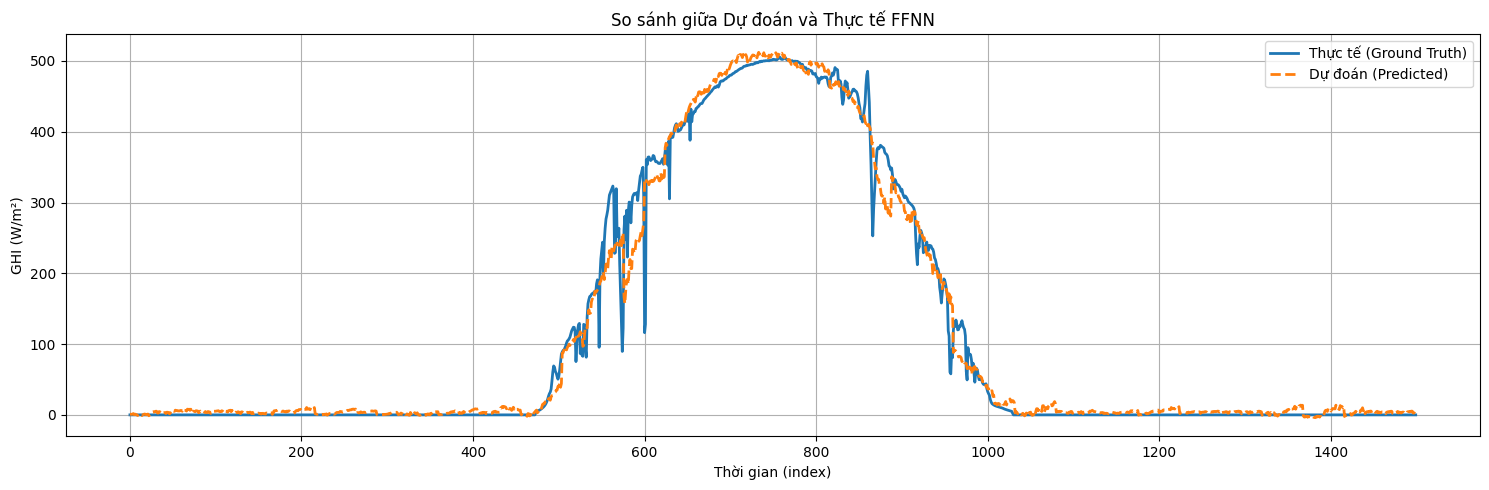

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(all_targets[:1500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:1500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế FFNN')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(model)

In [23]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
model = FFNN(seq_length=12, num_feature=8).to(device)

summary(model, input_size=(12, 8), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,208
            Linear-2                   [-1, 32]           2,080
            Linear-3                   [-1, 12]             396
Total params: 8,684
Trainable params: 8,684
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
